In [111]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, lfilter_zi
from scipy import signal
from mne_icalabel import label_components
# fastica, picard, infomax. Picard maybe better

In [112]:
df = pd.read_csv("C:/Users/JackC/Documents/GitHub/EEGcontroller/MeasurementSubgroup/Our_measurements/Measurement_prompt/EEGdata-2024-150--15-30-23.csv", sep=",")
end = df.shape[0]-5
fs = 250
df = df.iloc[:end, :8] # 3000 samples is 12 seconds of data
df

,FZ,C3,CZ,C4,PZ,PO7,OZ,PO8
0,231748.265625,272931.18750,415202.28125,359363.68750,242437.843750,276865.25000,248692.046875,245715.062500
1,232305.359375,273898.12500,416320.40625,359674.28125,243796.203125,277345.28125,249150.531250,246283.875000
2,232465.656250,273989.75000,416229.65625,359583.62500,244152.671875,277557.00000,249169.843750,246297.812500
3,232013.000000,273080.21875,415048.59375,359214.90625,243014.437500,277214.12500,248733.625000,245746.718750
4,231565.328125,272419.12500,414391.00000,359069.34375,241943.875000,276786.59375,248437.062500,245385.687500
...,...,...,...,...,...,...,...,...
71995,231481.468750,272675.12500,329643.18750,299217.90625,243017.828125,276694.93750,248242.593750,244771.640625
71996,230952.265625,271762.81250,328493.40625,298892.81250,241714.093750,276337.59375,247797.984375,244198.000000
71997,230709.000000,271520.15625,328382.00000,298912.03125,241160.046875,276046.65625,247684.078125,244086.968750
71998,231088.625000,272282.34375,329457.93750,299244.62500,242117.765625,276232.15625,248070.484375,244595.953125


In [113]:
def filter(data):
    data = signal.detrend(data, axis = 0)

    # Define the filter parameters
    lowcut = 2
    highcut = 30
    fs = 250  # Sampling frequency

    # Calculate the filter coefficients
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(8, [low, high], btype='band')

    # Apply the filter to each column of the DataFrame
    df_filt = lfilter(b, a, data, axis = 0)

    # import scipy.signal as signal

    # Define the notch filter parameters
    fs = 250  # Sampling frequency
    f0 = 50  # Notch frequency
    Q = 1 # Quality factor

    # Design the notch filter
    b, a = signal.iirnotch(f0, Q, fs)

    # Apply the filter to each column of the DataFrame
    df_filt1 = lfilter(b, a, df_filt, axis = 0)
    return df_filt1

In [114]:
df = filter(df)

In [115]:
# Constants
num_components = 8
allOutputs = df

channels = df.T

# create mne_info object
ch_names =        ['Fz', 
            'C3',  'Cz',  'C4', 
                   'Pz', 
            'PO7', 'Oz',  'PO8']

ch_type = ['eeg' for i in range(8)]
mne_info = mne.create_info(ch_names, float(250), ch_types=ch_type)

#create mne.raw object
raw = mne.io.RawArray(channels, mne_info)
raw.set_montage(mne.channels.make_standard_montage("standard_1005"))

Creating RawArray with float64 data, n_channels=8, n_times=72000
    Range : 0 ... 71999 =      0.000 ...   287.996 secs
Ready.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [174]:
#actual code
raw.filter(2, 30)

ica = mne.preprocessing.ICA(method='picard', fit_params=dict(ortho=False,extended=True), n_components=num_components, random_state=0)
#ica = mne.preprocessing.ICA(method='infomax', fit_params=dict(extended=True), n_components=num_components, random_state=0)
ica.fit(raw)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 1.9s.


Method,picard
Fit parameters,ortho=Falseextended=Truemax_iter=500
Fit,36 iterations on raw data (72000 samples)
ICA components,8
Available PCA components,8
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=8, n_times=72000
    Range : 0 ... 71999 =      0.000 ...   287.996 secs
Ready.


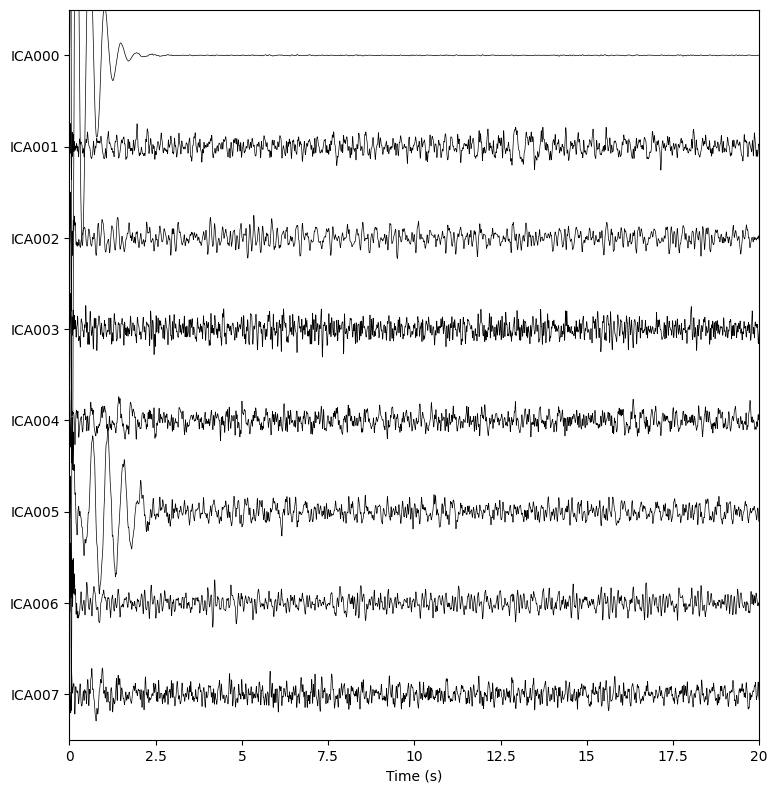

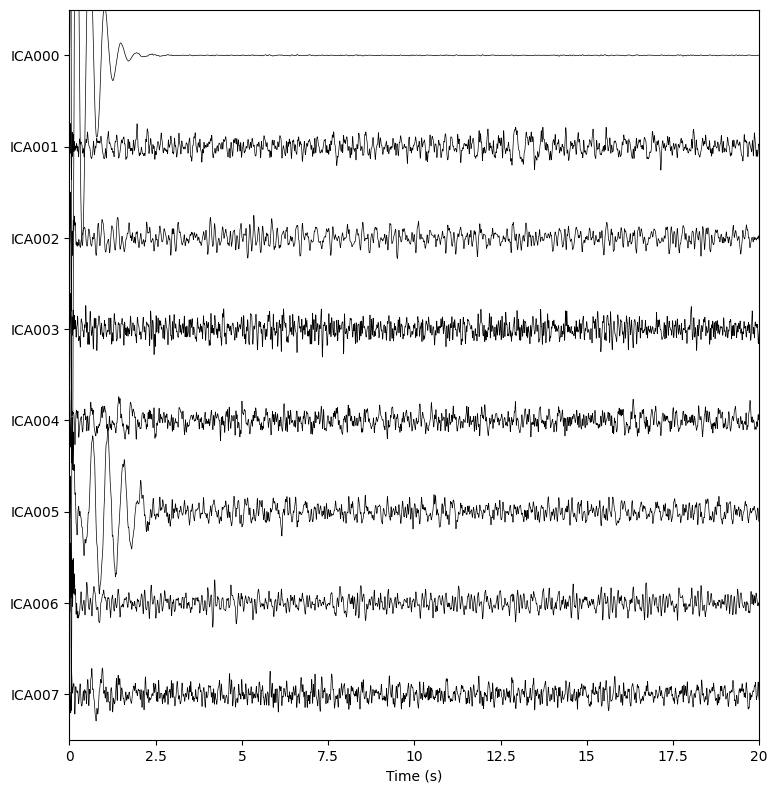

In [175]:
raw.load_data()
ica.plot_sources(raw, show_scrollbars=False)

In [176]:
# assuming you have a Raw and ICA instance previously fitted
labels = label_components(raw, ica, method='iclabel')
print(labels)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\JackC\AppData\Local\Temp\ipykernel_24884\2714741644.py:2: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  labels = label_components(raw, ica, method='iclabel')
C:\Users\JackC\AppData\Local\Temp\ipykernel_24884\2714741644.py:2: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(raw, ica, method='iclabel')


{'y_pred_proba': array([0.99436647, 0.7799111 , 0.96504134, 0.4964289 , 0.950189  ,
       0.9950615 , 0.9997082 , 0.97397244], dtype=float32), 'labels': ['brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain', 'brain']}


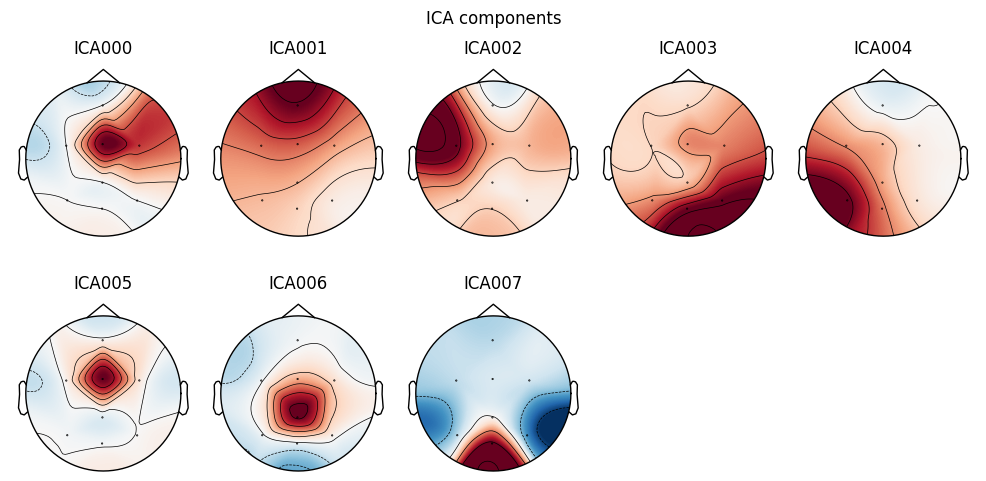

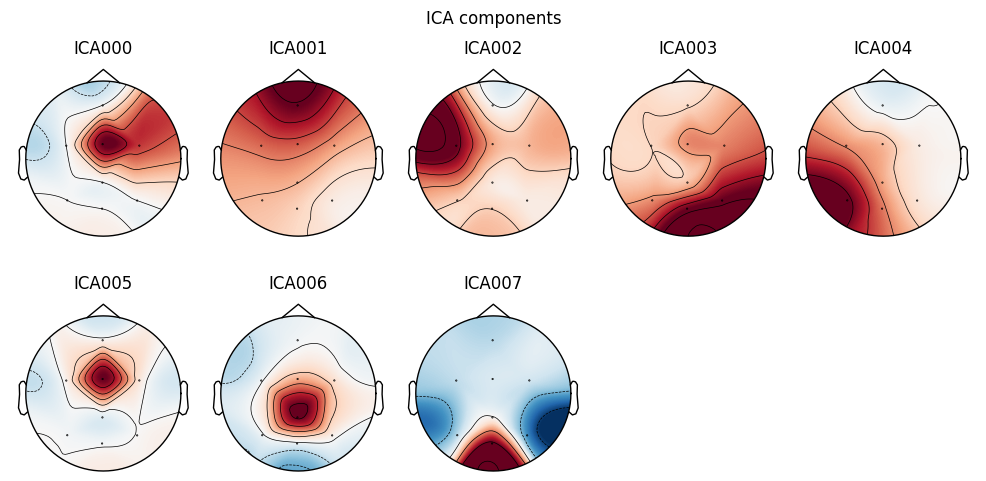

In [177]:
ica.plot_components(picks=range(num_components), ch_type='eeg')


Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components


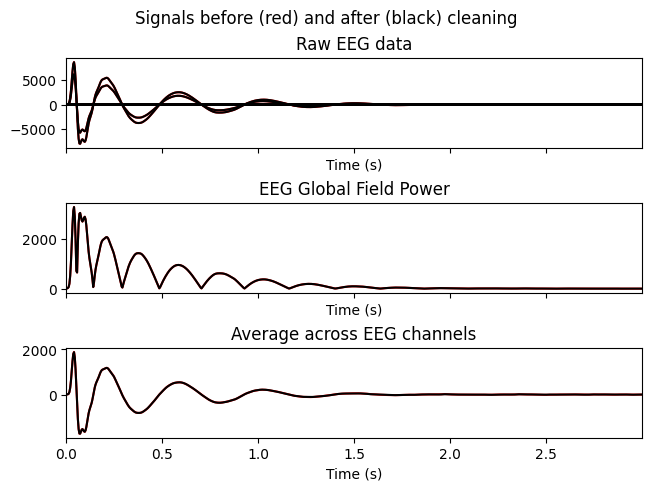

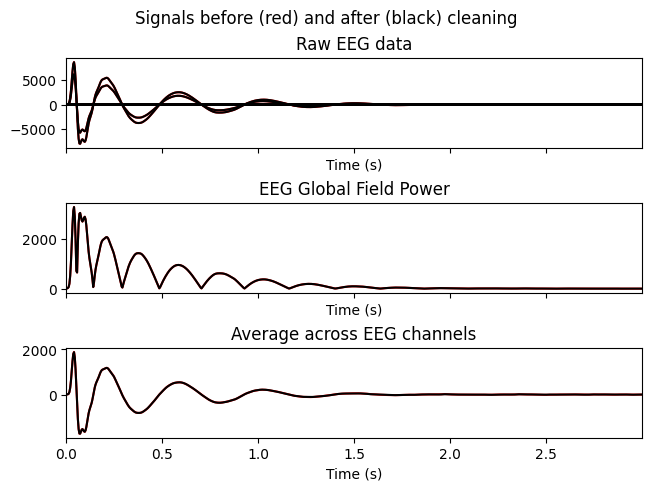

In [178]:
# blinks
ica.plot_overlay(raw, exclude=[1], picks="eeg")

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated


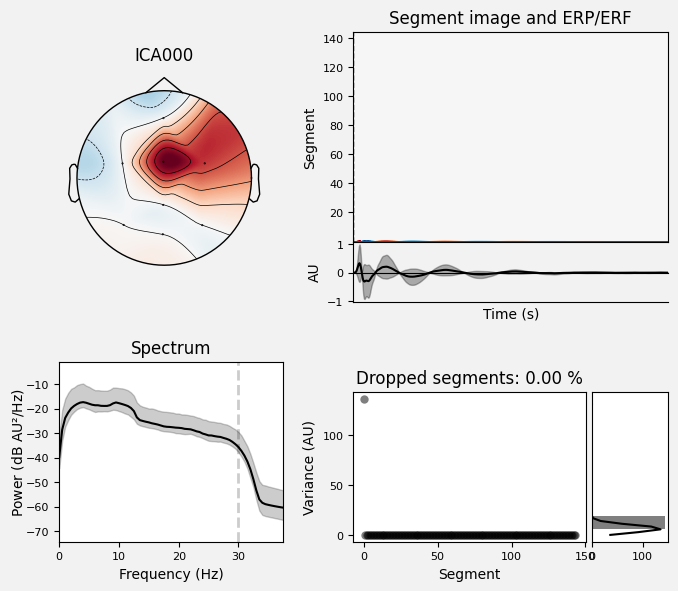

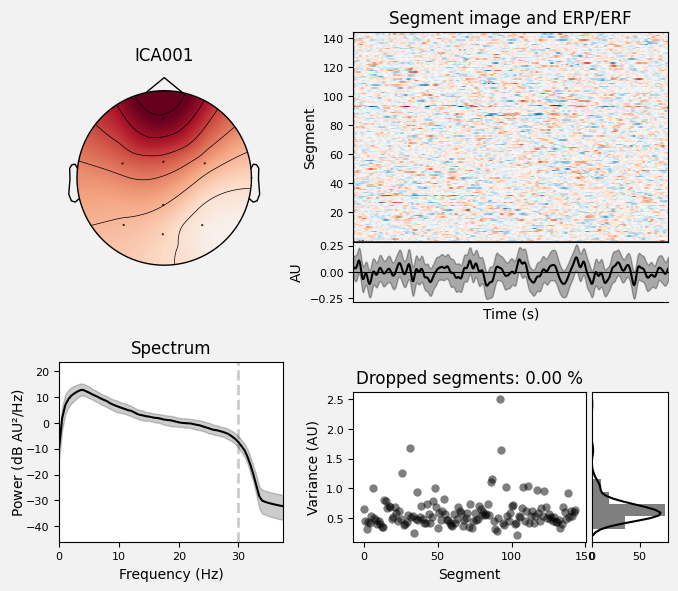

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [179]:
ica.plot_properties(raw, picks=[0, 1])

In [182]:
ica.exclude = [0,4,5]  # indices chosen based on various plots above

# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = raw.copy()
ica.apply(reconst_raw)

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 3 ICA components
    Projecting back using 8 PCA components


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,2.00 Hz
Lowpass,30.00 Hz


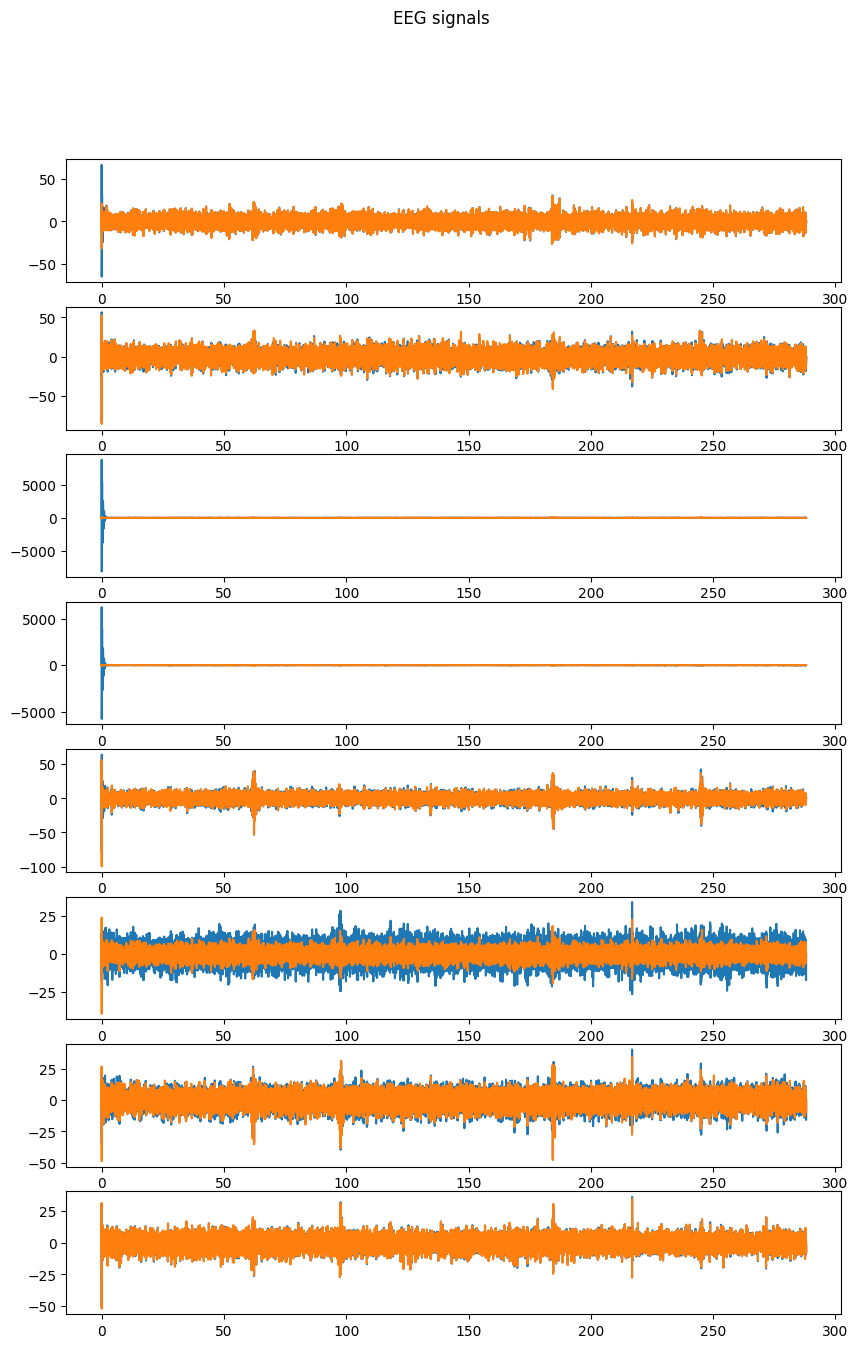

In [183]:
raw_array = raw[:][0].T
reconst_raw_array = reconst_raw[:][0].T

x1 = np.linspace(0, end/fs, end, endpoint=True)

fig, axs = plt.subplots(8, figsize=(10 , 15))
fig.suptitle('EEG signals')
for i in range(8):
    axs[i].plot(x1,raw_array[:,i])
    axs[i].plot(x1,reconst_raw_array[:,i])